In [1]:
!pip install seaborn

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import collections

import numpy
import pandas
import seaborn as sns
import scipy.stats

from hetmech.hetmat import HetMat

%matplotlib inline

In [3]:
hetmat = HetMat('../data/hetionet-v1.0.hetmat/')

In [4]:
select_metapaths = ['DaGiG', 'DaGbC', 'DtC', 'DuGcG', 'DdGcG', 'DdGeA']

dwpc_path = hetmat.directory.joinpath('adjusted-path-counts', 'dwpc-0.5', 'adjusted-dwpcs')

values_dict = {}
for metapath in select_metapaths:
    df = pandas.read_table(dwpc_path.joinpath(f'{metapath}.tsv'))
    values_dict[metapath] = df.replace([numpy.inf, -numpy.inf], numpy.nan).dropna()['z-dwpc'].values

In [5]:
def ks_norm_test(data, sided='less'):
    """
    Perform a Kolmogorov-Smirnov test to compare the distribution of Z-DWPC values with
    the standard normal distribution. KS statistic returned is equal to the the area
    of the data PDF above the standard normal PDF that lies outside the intersection of
    the two curves. For more information, see 
    https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
    """
    data = numpy.sort(numpy.asarray(data))
    cdf = numpy.arange(0, len(data)) / len(data)
    norm_cdf = scipy.stats.norm.cdf(data)
    diff = norm_cdf - cdf

    info = collections.OrderedDict({'z': data, 'data-cdf': cdf, 'norm-cdf': norm_cdf, 'ks': diff})
    df = pandas.DataFrame.from_dict(info)
    
    if sided == 'two':
        df['ks'] = abs(df['ks'])
    elif sided == 'greater':
        df['ks'] = -df['ks']
        
    ksstat = df.iloc[df['ks'].idxmax(axis=1)].to_dict()
    
    # Calculate p-value using the limiting value Kolmogorov-Smirnov distribution See: https://git.io/vhVpc
    p = scipy.special.kolmogorov(ksstat['ks'] * numpy.sqrt(len(data)))
    ksstat['p-value'] = p
    
    return ksstat

In [6]:
ks_norm_test(values_dict['DdGcG'])

{'z': -0.409456099691775,
 'data-cdf': 0.07338112905026603,
 'norm-cdf': 0.34110248866673387,
 'ks': 0.2677213596164678,
 'p-value': 0.0}

This method should be compared with the built-in scipy method. Unlike that method, we return the Z-value of where PDFs intersect, or the coordinate where the KS statistic is found.

In [7]:
scipy.stats.kstest(values_dict['DdGcG'], 'norm', alternative='less')

KstestResult(statistic=0.2677213596164678, pvalue=0.0)

/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/michael/.conda/envs/hetmech/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/michael/.conda/envs/he

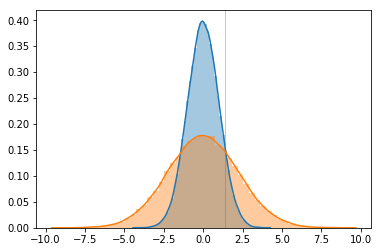

In [8]:
draws = numpy.random.normal(0, numpy.sqrt(5), 100000)
st_norm = numpy.random.normal(0, 1, 100000)
x1 = 100 * [1.364]
sns.distplot(st_norm)
sns.distplot(draws)
sns.distplot(x1)

In [9]:
scipy.stats.kstest(draws, 'norm', alternative='less')

KstestResult(statistic=0.18409389048597358, pvalue=0.0)

### Explanation

The KS statistic above is equal to the difference in areas to the right of the green line above. Since the orange distribution has a greater variance, it has a higher area beyond the intersection. The alternate hypothesis that the orange is 'less' than the blue means that the CDF of the orange distribution is below the CDF of the blue curve. In this case, this hypothesis is correct. Orange CDF < Blue CDF and Orange PDF > Blue PDF.